## Titanic_2
- 참고한 커널
    1. [캐글코리아 타이타닉 튜토리얼 2(EDA, 시각화, 머신러닝)](https://kaggle-kr.tistory.com/18?category=868316)
    2. [Titanic Top 4% with ensemble modeling](https://www.kaggle.com/yassineghouzam/titanic-top-4-with-ensemble-modeling)

In [1]:
import numpy as np
import pandas as pd
from pandas import Series
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn')
sns.set(font_scale=2.5)
# plotly -> modern chart 만들기
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

#ignore warnings
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

df_train = pd.read_csv("../input/titanic_train.csv")
df_test = pd.read_csv("../input/titanic_test.csv")
df_train['FamilySize'] = df_train['SibSp'] + df_train['Parch'] + 1 # 자신을 더하기
df_test['FamilySize'] = df_test['SibSp'] + df_test['Parch'] + 1

df_test[df_test['Fare'].isnull()]['Fare'] = df_test['Fare'].mean()

df_train['Fare'] = df_train['Fare'].map(lambda i: np.log(i) if i > 0 else 0)
df_test['Fare'] = df_test['Fare'].map(lambda i: np.log(i) if i > 0 else 0)

df_train['Ticket_count'] = df_train['Ticket'].value_counts()[df_train['Ticket']].values

## 3. Feature engineering
- null data 채우기 -> feature의 통계량 또는 다른 아이디어. 어떻게 채우느냐에 따라 모델 성능이 좌지우지됨
- 실제 모델의 학습에 쓰려고 하는 것이므로, train과 test 모두에 똑같이 적용해야 함!!

### 3.1 null 채우기
#### 3.1.1 Age null 채우기
- Age는 null이 20% 정도 됨. title(Mr., Mrs. 등) + statistics 통해 채우기

In [2]:
# 알파벳 + .까지 추출하기
df_train['Initial'] = df_train['Name'].str.extract('([A-Za-z]+)\.')
df_test['Initial'] = df_test['Name'].str.extract('([A-Za-z]+)\.')

In [3]:
pd.crosstab(df_train['Initial'], df_train['Sex']).T.style.background_gradient(
cmap='summer_r')

Initial,Capt,Col,Countess,Don,Dr,Jonkheer,Lady,Major,Master,Miss,Mlle,Mme,Mr,Mrs,Ms,Rev,Sir
Sex,,,,,,,,,,,,,,,,,
female,0,0,1,0,1,0,1,0,0,182,2,1,0,125,1,0,0
male,1,2,0,1,6,1,0,2,40,0,0,0,517,0,0,6,1


In [111]:
# 남/여가 구분되는게 많음!! 위 테이블 참고하여 남/여가 쓰는 initial 구분해 보기
# 이렇게 무식하게 말고, crosstab에서 한쪽 카운트가 0이면 구분할 수 없나?
sex_init = pd.crosstab(df_train['Initial'], df_train['Sex']).T
sex_init

Initial,Capt,Col,Countess,Don,Dr,Jonkheer,Lady,Major,Master,Miss,Mlle,Mme,Mr,Mrs,Ms,Rev,Sir
Sex,,,,,,,,,,,,,,,,,
female,0,0,1,0,1,0,1,0,0,182,2,1,0,125,1,0,0
male,1,2,0,1,6,1,0,2,40,0,0,0,517,0,0,6,1


In [33]:
# 아래처럼 하고 싶은데, 여자는 Miss/Mrs로 구분됨. 그래서 걍 커널대로 하기
# 이렇게 하면 Dr(여1, 남6) 빼고 모두 수정됨. 아래 커널 코드는 Dr를 그냥
# Mr로 했음
# 커널대로 할거면 이렇게 하지 말기!! 실행 결과만 참고

# for col in sex_init.columns:
#     if sex_init.loc['female', col] == 0:
#         df_train.loc[(df_train['Initial'] == col), 'Initial'] = "Mr"
#     elif sex_init.loc['male', col] == 0:
#         df_train.loc[(df_train['Initial'] == col), 'Initial'] = "Miss"
#     else:
#         df_train.loc[(df_train['Initial'] == col), 'Initial'] = "Other"
# pd.crosstab(df_train['Initial'], df_train['Sex']).T

Initial,Miss,Mr,Other
Sex,,,
female,313,0,1
male,0,571,6


In [4]:
df_train['Initial'].replace(
    ['Mlle','Mme','Ms','Dr','Major','Lady','Countess','Jonkheer',
     'Col','Rev','Capt','Sir','Don', 'Dona'],
    ['Miss','Miss','Miss','Mr','Mr','Mrs','Mrs','Other',
     'Other','Other','Mr','Mr','Mr', 'Mr'],
    inplace=True)

df_test['Initial'].replace(
    ['Mlle','Mme','Ms','Dr','Major','Lady','Countess','Jonkheer',
     'Col','Rev','Capt','Sir','Don', 'Dona'],
    ['Miss','Miss','Miss','Mr','Mr','Mrs','Mrs','Other',
     'Other','Other','Mr','Mr','Mr', 'Mr'],
    inplace=True)

In [5]:
df_train.groupby('Initial').mean()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,FamilySize,Ticket_count
Initial,,,,,,,,,
Master,414.975000,0.575000,2.625000,4.574167,2.300000,1.375000,3.340710,4.675000,3.750000
Miss,411.741935,0.704301,2.284946,21.860000,0.698925,0.537634,3.123713,2.236559,2.075269
Mr,455.880907,0.162571,2.381853,32.739609,0.293006,0.151229,2.651507,1.444234,1.476371
Mrs,456.393701,0.795276,1.984252,35.981818,0.692913,0.818898,3.443751,2.511811,2.078740
Other,564.444444,0.111111,1.666667,45.888889,0.111111,0.111111,2.641605,1.222222,1.333333


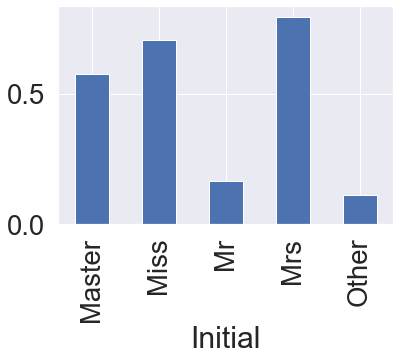

In [114]:
df_train.groupby('Initial')['Survived'].mean().plot.bar()
# 색은 어떻게 커널처럼 다채롭게 하지?

In [6]:
for col in df_train.columns:
    print(col, "null 비율: {:.1f}%".format(
          100 * df_train[col].isnull().sum() / df_train.shape[0]))

PassengerId null 비율: 0.0%
Survived null 비율: 0.0%
Pclass null 비율: 0.0%
Name null 비율: 0.0%
Sex null 비율: 0.0%
Age null 비율: 19.9%
SibSp null 비율: 0.0%
Parch null 비율: 0.0%
Ticket null 비율: 0.0%
Fare null 비율: 0.0%
Cabin null 비율: 77.1%
Embarked null 비율: 0.2%
FamilySize null 비율: 0.0%
Ticket_count null 비율: 0.0%
Initial null 비율: 0.0%


## 본격적으로 Null 채우기
- 통계량 활용 or null이 없는 데이터 기반 머신러닝 알고리즘으로 예측
- 여기선 train set의 통계량 활용.
    - 항상 test는 unseen으로 두어야 함. train에서 얻은 통계량 기반으로 test의 null data를 채워야 함

In [116]:
df_train.groupby('Initial').mean()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,FamilySize
Initial,,,,,,,,
Master,414.975000,0.575000,2.625000,4.574167,2.300000,1.375000,3.340710,4.675000
Miss,411.741935,0.704301,2.284946,21.860000,0.698925,0.537634,3.123713,2.236559
Mr,455.880907,0.162571,2.381853,32.739609,0.293006,0.151229,2.651507,1.444234
Mrs,456.393701,0.795276,1.984252,35.981818,0.692913,0.818898,3.443751,2.511811
Other,564.444444,0.111111,1.666667,45.888889,0.111111,0.111111,2.641605,1.222222


- 그룹별 Age의 평균으로 null 채우기
- pandas DataFrame은 boolean array를 이용해 인덱싱하는 것이 편리함(isnull)

In [7]:
mean_age_by_init = df_train.groupby('Initial').mean()['Age']
for initial in mean_age_by_init.index:
    df_train.loc[(df_train['Age'].isnull()) &
                  (df_train['Initial'] == initial), 'Age'] = round(mean_age_by_init[initial])
    df_test.loc[(df_test['Age'].isnull()) &
                  (df_test['Initial'] == initial), 'Age'] = round(mean_age_by_init[initial])

In [8]:
# 잘 된 것 확인
df_train['Age'].isnull().sum()
df_test['Age'].isnull().sum()

0

#### 3.1.2 Embarked(탑승 항구) null 채우기

In [9]:
print('Embarked has', sum(df_train['Embarked'].isnull()), 'Null values')
print('Embarked has', sum(df_test['Embarked'].isnull()), 'Null values')

Embarked has 2 Null values
Embarked has 0 Null values


In [10]:
# train에만 단 2개가 있고, S에 가장 많은 탑승객이 있었으므로 S로 채우기
df_train['Embarked'].fillna("S", inplace=True)
print('Embarked has', sum(df_train['Embarked'].isnull()), 'Null values')

Embarked has 0 Null values


### 3.2 Age 바꾸기(연속형 -> 범주형)
- information loss가 생길 수 있지만, 다양한 방법 소개하는 목적
- 모델링 할 때 연속형으로도 해 보기

In [11]:
# loc을 사용하여, 나이를 10살 간격으로 나누기
# 방법 1, 2가 같은 결과를 내는지 확인하기
# 방법 1
df_train['Age_cat'] = 0
df_train.loc[df_train['Age'] < 10, 'Age_cat'] = 0
df_train.loc[(10 <= df_train['Age']) & (df_train['Age'] < 20), 'Age_cat'] = 1
df_train.loc[(20 <= df_train['Age']) & (df_train['Age'] < 30), 'Age_cat'] = 2
df_train.loc[(30 <= df_train['Age']) & (df_train['Age'] < 40), 'Age_cat'] = 3
df_train.loc[(40 <= df_train['Age']) & (df_train['Age'] < 50), 'Age_cat'] = 4
df_train.loc[(50 <= df_train['Age']) & (df_train['Age'] < 60), 'Age_cat'] = 5
df_train.loc[(60 <= df_train['Age']) & (df_train['Age'] < 70), 'Age_cat'] = 6
df_train.loc[70 <= df_train['Age'], 'Age_cat'] = 7

#방법 2
def category_age(x):
    if x < 70:
        return x // 10
    else:
        return 7

df_train['Age_cat_2'] = df_train['Age'].apply(category_age)
#test에는 2번 방법만 적용
df_test['Age_cat'] = df_train['Age'].apply(category_age) 

In [12]:
print("1, 2번 방법 둘다 같은 결과를 내면 True 반환 ->",
     (df_train['Age_cat'] == df_train['Age_cat_2']).all())

1, 2번 방법 둘다 같은 결과를 내면 True 반환 -> True


In [13]:
# 확인했으니 중복되는 칼럼 제거
df_train.drop(['Age', 'Age_cat_2'], axis=1, inplace=True)
df_test.drop(['Age'], axis=1, inplace=True)

## 3.3 Initial, Embarked, Sex 바꾸기(string to numeric)
- initial은 Mr, Mrs, Miss, Master, Other 5개 -> 수치화

In [14]:
df_train['Initial'] = df_train['Initial'].map(
{'Master':0, 'Miss':1, 'Mr':2, 'Mrs':3, 'Other':4})
df_test['Initial'] = df_test['Initial'].map(
{'Master':0, 'Miss':1, 'Mr':2, 'Mrs':3, 'Other':4})

- Embarked는 C,Q,S. 이것도 수치화
- 그전에 value_counts() 확인해 보기

In [15]:
print(df_train['Embarked'].unique())
df_train['Embarked'].value_counts()

['S' 'C' 'Q']


S    646
C    168
Q     77
Name: Embarked, dtype: int64

In [16]:
df_train['Embarked'] = df_train['Embarked'].map(
{'C':0, 'Q':1, 'S':2})
df_test['Embarked'] = df_test['Embarked'].map(
{'C':0, 'Q':1, 'S':2})

In [17]:
# null 사라졌는지 확인
df_train['Embarked'].isnull().any() # any -> 하나라도 있으면 True 반환

False

In [18]:
df_train['Sex'] = df_train['Sex'].map(
{'female':0, 'male':1})
df_test['Sex'] = df_test['Sex'].map(
{'female':0, 'male':1})

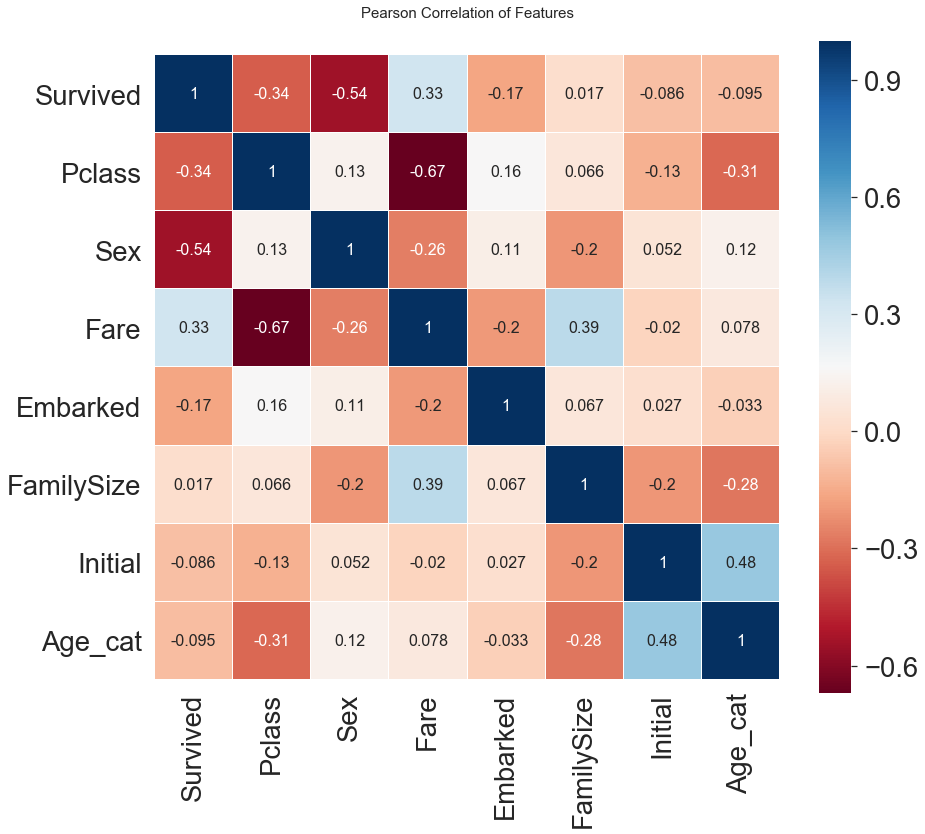

In [19]:
heatmap_data = df_train[['Survived', 'Pclass', 'Sex', 'Fare', 'Embarked',
                        'FamilySize', 'Initial', 'Age_cat']]

colormap = plt.cm.RdBu
plt.figure(figsize=(14, 12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(heatmap_data.astype(float).corr(), linewidths=0.1,
           vmax=1.0, square=True, cmap=colormap, linecolor='white',
           annot=True, annot_kws={"Size": 16})

del heatmap_data

- EDA에서도 확인했듯이 Sex, Pclass가 Survived와 상관관계가 어느 정도 있음
- Fare와 Embarked도
- 강한 상관관계를 보이는 feature들이 없음
    - 즉 모델 학습시 불필요한 feature가 없음.

## 3.4 One-Hot Encoding: Initial, Embarked
- 성별은 어차피 0,1 binary라서 안하는 듯
- pd.get_dummies 사용

In [20]:
df_train = pd.get_dummies(df_train, columns=['Initial'], prefix="Initial")
df_test = pd.get_dummies(df_test, columns=['Initial'], prefix="Initial")

In [21]:
df_train = pd.get_dummies(df_train, columns=['Embarked'], prefix="Embarked")
df_test = pd.get_dummies(df_test, columns=['Embarked'], prefix="Embarked")

- 카테고리 개수가 100개가 넘어가는 경우 column이 너무 많이 생겨 학습시 매우 버거울 수 있음. 이런 경우는 다음에 다룸

## 3.5 Drop columns

In [23]:
df_train.drop(['PassengerId', 'Name', 'SibSp', 'Parch', 'Ticket',
              'Cabin'], axis=1, inplace=True)
df_test.drop(['PassengerId', 'Name', 'SibSp', 'Parch', 'Ticket',
              'Cabin'], axis=1, inplace=True)

In [24]:
df_train.head()

,Survived,Pclass,Sex,Fare,FamilySize,Ticket_count,Age_cat,Initial_0,Initial_1,Initial_2,Initial_3,Initial_4,Embarked_0,Embarked_1,Embarked_2
0,0,3,1,1.981001,2,1,2,0,0,1,0,0,0,0,1
1,1,1,0,4.266662,2,1,3,0,0,0,1,0,1,0,0
2,1,3,0,2.070022,1,1,2,0,1,0,0,0,0,0,1
3,1,1,0,3.972177,2,2,3,0,0,0,1,0,0,0,1
4,0,3,1,2.085672,1,1,3,0,0,1,0,0,0,0,1


In [25]:
df_test.head()

,Pclass,Sex,Fare,FamilySize,Age_cat,Initial_0,Initial_1,Initial_2,Initial_3,Initial_4,Embarked_0,Embarked_1,Embarked_2,Ticket_count
0,3,1,2.057860,1,2.0,0,0,1,0,0,0,1,0,1
1,3,0,1.945910,2,3.0,0,0,0,1,0,0,0,1,1
2,2,1,2.270836,1,2.0,0,0,1,0,0,0,1,0,1
3,3,1,2.159003,1,3.0,0,0,1,0,0,0,0,1,1
4,3,0,2.508582,3,3.0,0,0,0,1,0,0,0,1,1


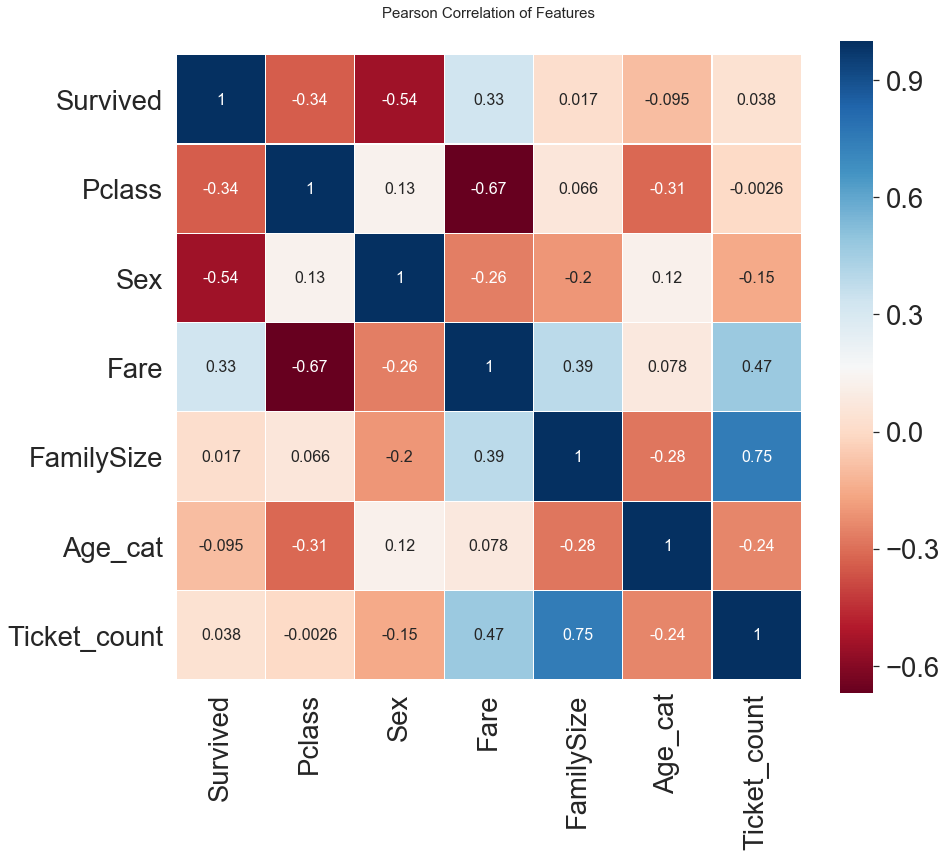

In [26]:
heatmap_data = df_train[['Survived', 'Pclass', 'Sex', 'Fare',
                        'FamilySize', 'Age_cat', 'Ticket_count']]

colormap = plt.cm.RdBu
plt.figure(figsize=(14, 12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(heatmap_data.astype(float).corr(), linewidths=0.1,
           vmax=1.0, square=True, cmap=colormap, linecolor='white',
           annot=True, annot_kws={"Size": 16})

del heatmap_data

In [27]:
# Ticket_count와 FamilySize는 0.75로 매우 강한 상관관계. 따라서 차원 축소
from sklearn.decomposition import PCA

#train에 대하여 학습
pca = PCA(n_components=1)
x_pca = pca.fit_transform(df_train[['FamilySize', 'Ticket_count']])
df_train['Family'] = x_pca.flatten()
df_train['Family'].head()

0   -0.416632
1   -0.416632
2   -1.198479
3    0.206838
4   -1.198479
Name: Family, dtype: float64

In [28]:
#test는 transform만
df_test['Family'] = pca.transform(
    df_test[['FamilySize', 'Ticket_count']]).flatten()
df_test['Family'].head()

0   -1.198479
1   -0.416632
2   -1.198479
3   -1.198479
4    0.365215
Name: Family, dtype: float64

In [163]:
df_train.head()

,Survived,Pclass,Sex,Fare,FamilySize,Age_cat,Initial_0,Initial_1,Initial_2,Initial_3,Initial_4,Embarked_0,Embarked_1,Embarked_2,Ticket_count,Family
0,0,3,1,1.981001,2,2,0,0,1,0,0,0,0,1,1,-0.416632
1,1,1,0,4.266662,2,3,0,0,0,1,0,1,0,0,1,-0.416632
2,1,3,0,2.070022,1,2,0,1,0,0,0,0,0,1,1,-1.198479
3,1,1,0,3.972177,2,3,0,0,0,1,0,0,0,1,2,0.206838
4,0,3,1,2.085672,1,3,0,0,1,0,0,0,0,1,1,-1.198479


In [29]:
# FamilySize, Ticket_count 열 제거
df_train.drop(['FamilySize', 'Ticket_count'], axis=1, inplace=True)
df_test.drop(['FamilySize', 'Ticket_count'], axis=1, inplace=True)

In [30]:
df_train.head()

,Survived,Pclass,Sex,Fare,Age_cat,Initial_0,Initial_1,Initial_2,Initial_3,Initial_4,Embarked_0,Embarked_1,Embarked_2,Family
0,0,3,1,1.981001,2,0,0,1,0,0,0,0,1,-0.416632
1,1,1,0,4.266662,3,0,0,0,1,0,1,0,0,-0.416632
2,1,3,0,2.070022,2,0,1,0,0,0,0,0,1,-1.198479
3,1,1,0,3.972177,3,0,0,0,1,0,0,0,1,0.206838
4,0,3,1,2.085672,3,0,0,1,0,0,0,0,1,-1.198479


In [31]:
df_test.head()

,Pclass,Sex,Fare,Age_cat,Initial_0,Initial_1,Initial_2,Initial_3,Initial_4,Embarked_0,Embarked_1,Embarked_2,Family
0,3,1,2.057860,2.0,0,0,1,0,0,0,1,0,-1.198479
1,3,0,1.945910,3.0,0,0,0,1,0,0,0,1,-0.416632
2,2,1,2.270836,2.0,0,0,1,0,0,0,1,0,-1.198479
3,3,1,2.159003,3.0,0,0,1,0,0,0,0,1,-1.198479
4,3,0,2.508582,3.0,0,0,0,1,0,0,0,1,0.365215


## 4. 머신러닝 모델 만들기, train set을 이용하여 예측

In [32]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.model_selection import train_test_split

### 4.1 준비 - train, valid, test set 나누기

In [33]:
X_train = df_train.drop('Survived', axis=1).values # X
target_label = df_train['Survived'].values # y
X_test = df_test.values

In [34]:
X_tr, X_vld, y_tr, y_vld = train_test_split(X_train, target_label,
test_size=0.3, random_state=2018)

### 4.2 model selection, prediction

In [35]:
model = RandomForestClassifier()
model.fit(X_tr, y_tr)
prediction = model.predict(X_vld)

In [36]:
print("총 {}명 중 {:.2f}% 정확도로 생존을 맞춤".format(
y_vld.shape[0], 100 * metrics.accuracy_score(prediction, y_vld)))

총 268명 중 85.07% 정확도로 생존을 맞춤


### 4.3 Feature Importance
- 영향을 많이 준 feature 확인

In [37]:
feature_importance = model.feature_importances_
Series_feat_imp = pd.Series(feature_importance, index=df_test.columns)

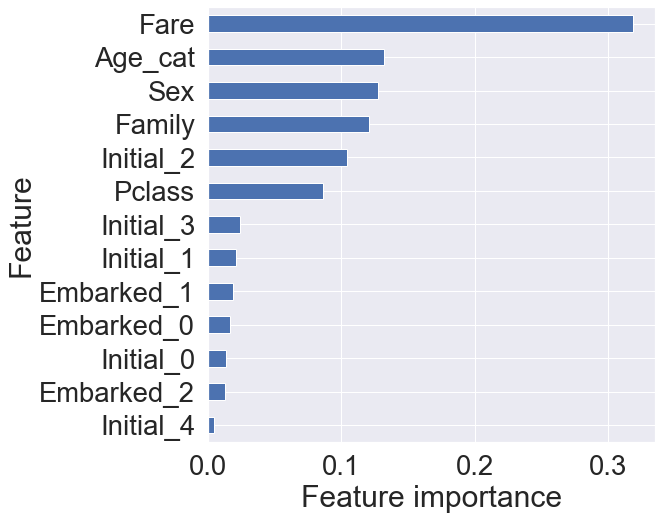

In [38]:
plt.figure(figsize=(8, 8))
Series_feat_imp.sort_values().plot.barh()
plt.xlabel('Feature importance')
plt.ylabel('Feature')
plt.show()

- 이 Importance는 지금 모델에서의 중요성. 다른 모델 사용하면 다르게 나올 수 있음
- Fare가 중요한 feature라고 판단할 수는 있지만, 결국 모델에 귀속되는 하나의 결론이므로 좀 더 살펴보아야 함

## 4.4 Test set으로 예측

In [94]:
submission = pd.read_csv('../input/gender_submission.csv')
submission.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [181]:
prediction = model.predict(X_test)
submission['Survived'] = prediction

In [182]:
submission.to_csv('./my_first_submission.csv', index=False)
# 결과: 정확도 0.73

## 5. Keras 모델 만들어서 정확도 높여보기

In [51]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten

In [41]:
print(X_tr.shape)
print(y_tr.shape)

(623, 13)
(623,)


In [66]:
model = Sequential()
model.add(Dense(256, activation='relu', input_shape=(13,)))
model.add(Dense(1, activation='softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 256)               3584      
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 257       
Total params: 3,841
Trainable params: 3,841
Non-trainable params: 0
_________________________________________________________________


In [69]:
# compile the model
model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])

In [78]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

# train the model
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.3, verbose=0,
                             patience=2, min_lr = 0.0001)
hist = model.fit(X_tr, y_tr, batch_size=20, epochs=20,
                validation_data=(X_vld, y_vld), callbacks=[reduce_lr],
                verbose=0, shuffle=True)

In [79]:
prediction = model.predict(X_vld)
print("총 {}명 중 {:.2f}% 정확도로 생존을 맞춤".format(
y_vld.shape[0], 100 * metrics.accuracy_score(prediction, y_vld)))

총 268명 중 35.82% 정확도로 생존을 맞춤


- Dense는 잘 맞지 않는 모델인 듯
- 캐글코리아 커널(ensemble modeling) 참고하기
- **KIC 수업 내용 중 타이타닉 한것도 참고하기!!**

In [80]:
from collections import Counter

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve

In [81]:
kfold = StratifiedKFold(n_splits=10)

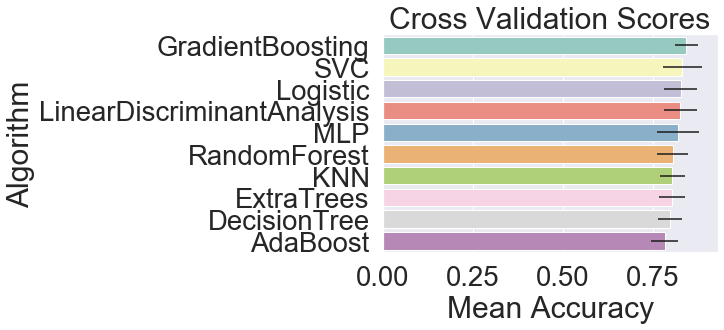

In [86]:
random_state = 2
classifiers = []
classifiers.append(SVC(random_state=random_state))
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(DecisionTreeClassifier(
random_state=random_state), random_state=random_state, learning_rate=0.1))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(MLPClassifier(random_state=random_state))
classifiers.append(KNeighborsClassifier())
classifiers.append(LogisticRegression(random_state = random_state))
classifiers.append(LinearDiscriminantAnalysis())

cv_results = []
for classifier in classifiers:
    cv_results.append(cross_val_score(classifier, X=X_train,
    y=target_label, scoring='accuracy', cv = kfold, n_jobs=4))
    
cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())
    
cv_res = pd.DataFrame({"CrossValMeans":cv_means, "CrossValerrors":cv_std,
                      "Algorithm":["SVC", "DecisionTree", "AdaBoost",
"RandomForest", "ExtraTrees", "GradientBoosting",
"MLP","KNN","Logistic","LinearDiscriminantAnalysis"]})

g = sns.barplot("CrossValMeans", "Algorithm", data = cv_res.sort_values(
    by='CrossValMeans', ascending=False), palette="Set3", 
                orient="h", **{'xerr':cv_std})
g.set_xlabel("Mean Accuracy")
g = g.set_title("Cross Validation Scores")

In [87]:
cv_res.sort_values(by='CrossValMeans', ascending=False)

,CrossValMeans,CrossValerrors,Algorithm
5,0.842917,0.042926,GradientBoosting
0,0.831644,0.030960,SVC
8,0.827188,0.033287,Logistic
9,0.826051,0.037601,LinearDiscriminantAnalysis
6,0.820496,0.035163,MLP
3,0.804765,0.046569,RandomForest
7,0.803628,0.036642,KNN
4,0.802569,0.057954,ExtraTrees
1,0.798023,0.053382,DecisionTree
2,0.782329,0.045456,AdaBoost


- CrossValMeans가 높은 GradientBoosting, SVC, Logistic, LDA, MLP 선택
- 이 모델들의 hyper parameter 튜닝

In [89]:
# GBC
GBC = GradientBoostingClassifier()
gb_param_grid = {'loss': ["deviance"],
                'n_estimators': [100, 200, 300],
                'learning_rate': [0.1, 0.05, 0.01],
                'max_depth': [4, 8],
                'min_samples_leaf': [100, 150],
                'max_features': [0.3, 0.1]}

gsGBC = GridSearchCV(GBC, param_grid=gb_param_grid, cv=kfold,
                    scoring='accuracy', n_jobs=4, verbose=1)
gsGBC.fit(X_train, target_label)

GBC_best = gsGBC.best_estimator_

#Best score
gsGBC.best_score_

Fitting 10 folds for each of 72 candidates, totalling 720 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.9s
[Parallel(n_jobs=4)]: Done 307 tasks      | elapsed:   12.4s
[Parallel(n_jobs=4)]: Done 713 out of 720 | elapsed:   25.2s remaining:    0.1s
[Parallel(n_jobs=4)]: Done 720 out of 720 | elapsed:   25.4s finished
C:\Users\ejesu\.conda\envs\test\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning:

The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.



0.8271604938271605

In [90]:
# SVC
SVMC = SVC(probability=True)
svc_param_grid = {'kernel': ['rbf'], 'gamma': [0.001, 0.01, 0.1, 1],
                 'C': [1, 10, 50, 100, 200, 300, 1000]}

gsSVMC = GridSearchCV(SVMC, param_grid=svc_param_grid,
                     cv=kfold, scoring='accuracy', n_jobs=4, verbose=1)

gsSVMC.fit(X_train, target_label)

SVMC_best = gsSVMC.best_estimator_

# Best Score
gsSVMC.best_score_

Fitting 10 folds for each of 28 candidates, totalling 280 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    2.7s
[Parallel(n_jobs=4)]: Done 280 out of 280 | elapsed:   24.2s finished


0.8316498316498316

- learning curve, feature importance 시각화는 일단 생략
### Combining models

In [92]:
votingC = VotingClassifier(estimators=[('gbc', GBC_best),
                            ('svc', SVMC_best)], voting='soft', n_jobs=4)

votingC = votingC.fit(X_train, target_label)

In [95]:
prediction = votingC.predict(X_test)
submission['Survived'] = prediction
submission.to_csv('./my_second_submission.csv', index=False)